In [2]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

In [100]:
#Number of simulation
n=103

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file


if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,:,:,:]
q=dataset.variables['q'][:,:,:,:]

print("psi shape",psi.shape)
#Lecture des paramètres :

param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']

la simulation chargée est: dahu_103
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (199, 1, 769, 769)
{'NX': 768.0, 'NY': 768.0, 'nl': 1.0, 'Lx': 9.42477822303772, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 6.03e-05, 'tend': 1576800000000.0, 'dt_out': 50.0}


(199, 769, 769)
Error = -47.4999926031705 %
Energy_diss_drag/Energy_injected 37.456 %


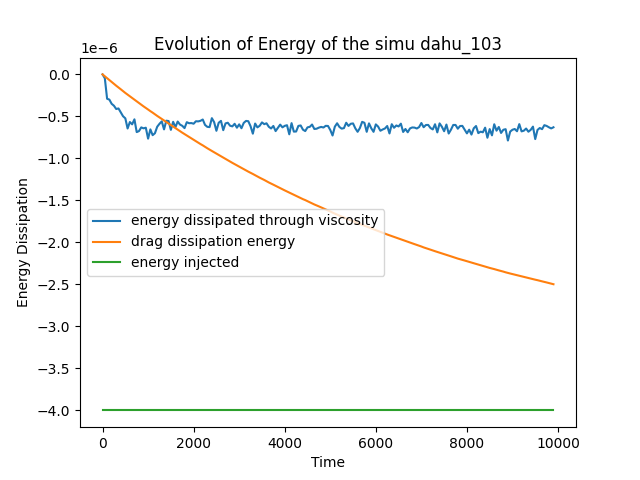

In [109]:
time_start =0
psi_data = psi[-time_start:, 0, :, :]
q_data = q[-time_start:, 0, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]

Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

if n_hyper==6:
    #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
    palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
    enstro_diss=-nu_hyper*palenstro_tot 

#Dans le cas ou l'hyper visocisté est égale à 4:
elif n_hyper==4:    

    enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

mean_enstro_diss=np.mean(enstro_diss[:])
mean_energy_diss=np.mean(energy_diss[:])
mean_energy_inj=np.mean(energy_inj[:])

#computing the error of the energy dissipation
print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

plt.figure()

plt.plot(t[-time_start:],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[-time_start:],energy_diss,label='drag dissipation energy')
plt.plot(t[-time_start:],-energy_inj,label='energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()


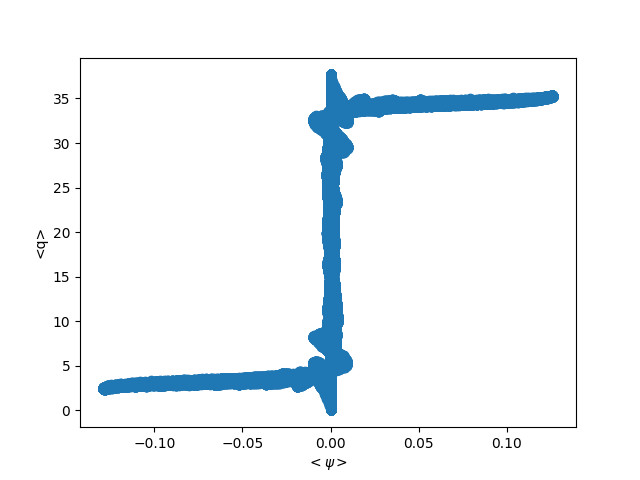

In [102]:
#We plot the mean streamfunction  and the mean q
startt=0

q_mean = np.mean(q[startt:,0,:,:],axis=0)
psi_mean= np.mean(psi[startt:,0,:,:],axis=0)
X,Y=np.meshgrid(x,y)

plt.figure()
plt.scatter(psi_mean,q_mean+beta*Y)
plt.xlabel(r'$<\psi>$')
plt.ylabel('<q>')
plt.show()




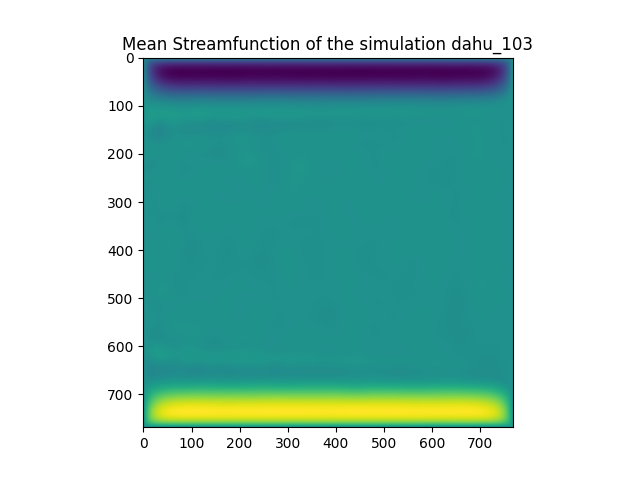

In [103]:
plt.figure()
plt.imshow(psi_mean,vmax=np.max(psi_mean))#+beta*Y)
plt.title('Mean Streamfunction of the simulation '+str(simu_name))
plt.savefig('./figures/jets/psi_mean_'+str(simu_name)+'.png')
plt.show()


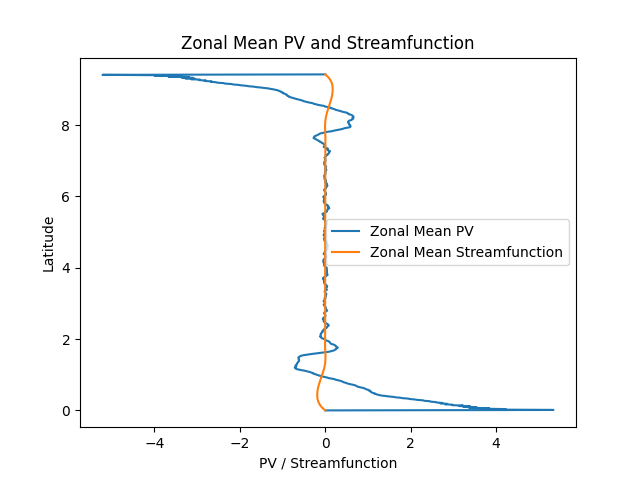

In [104]:


q_zonal_mean = np.mean(q_data, axis=2)  # Averaging over the longitude axis
Psi_zonal_mean = np.mean(psi_data, axis=2)


time_start = 20# Start time index

plt.figure()
plt.plot(np.mean(q_zonal_mean[time_start:, :],axis=0),y,label='Zonal Mean PV')
plt.plot(np.mean(Psi_zonal_mean[time_start:, :],axis=0),y, label='Zonal Mean Streamfunction')
plt.ylabel('Latitude')
plt.xlabel('PV / Streamfunction')
plt.legend()
plt.title('Zonal Mean PV and Streamfunction')
plt.show()


/tmp/ipykernel_122368/18327531.py:20: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_122368/18327531.py:21: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


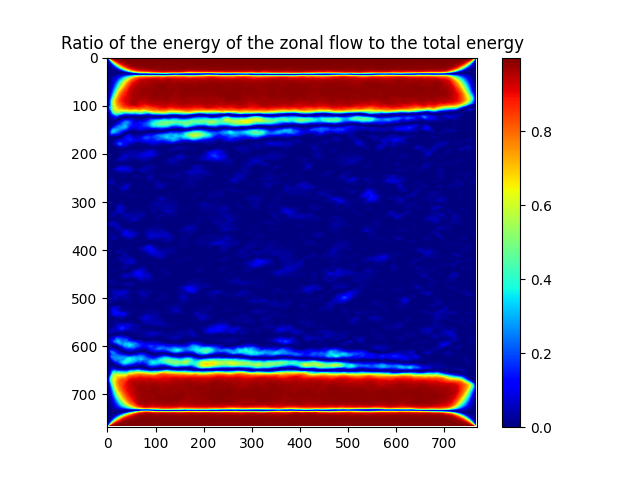

In [105]:
tstart=-30


#Computing the energy ratios
delta=Lx/nx

u,v=op.calc_uv(psi[tstart:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)

#Mean energy
energy_tot=np.mean(energy,axis=0)

#Energy of the mean zonal flow
energy_zonal=0.5*(np.mean(u,axis=0)**2)

#Energy of the mean flow
energy_mean=0.5*(np.mean(np.sqrt(u**2+v**2),axis=0)**2)


ratioUzonUtot=energy_zonal/energy_tot
ratioUmeanUtot=energy_mean/energy_tot


plt.figure()
plt.imshow(ratioUzonUtot, cmap='jet')

plt.colorbar()
plt.title('Ratio of the energy of the zonal flow to the total energy')

plt.show()



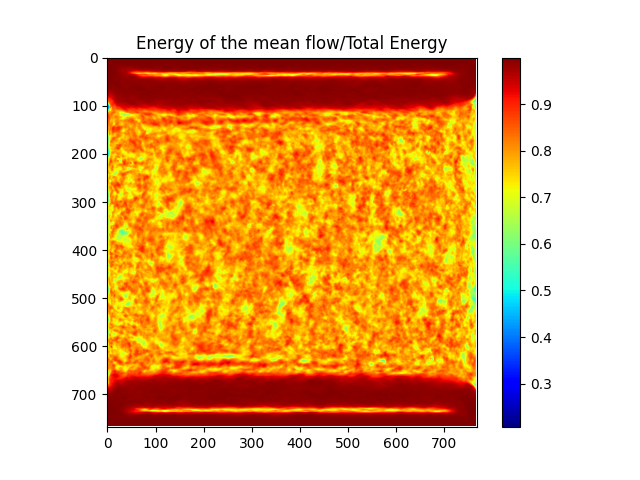

In [106]:
plt.figure()
plt.imshow(ratioUmeanUtot, cmap='jet')
plt.colorbar()
plt.title('Energy of the mean flow/Total Energy')
plt.show()

# Measuring the size of the border jets

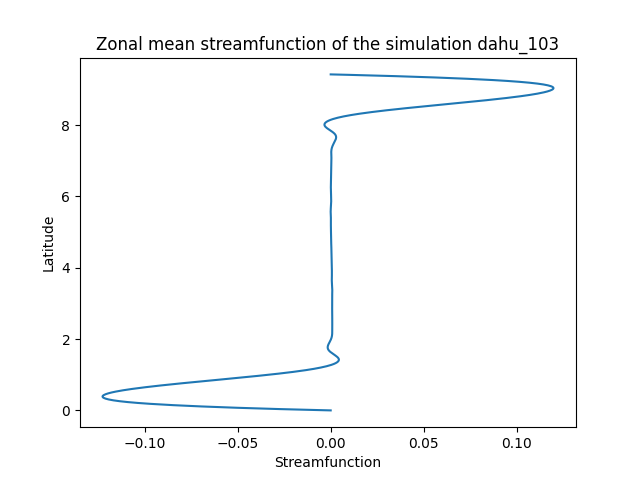

Zero crossings= [0.        1.2640002 1.6198838 1.9757673 5.4977875 5.608234  7.84171
 8.148506  9.412506 ]
Jet size= 1.2639999389648438
Rhines length= 1.5943568884527226
Domain Size= 9.424778


In [112]:
#plotting the zonnaly averaged stream function with respect to the latitude

psi_zonal_mean = np.mean(psi_data, axis=2)
psi_zonal_mean_temp = np.mean(psi_zonal_mean, axis=0)
plt.figure()
plt.plot(psi_zonal_mean_temp,y)
plt.xlabel('Streamfunction')
plt.ylabel('Latitude')
plt.title('Zonal mean streamfunction of the simulation '+str(simu_name)) 
plt.savefig('./figures/jets/psi_zonal_mean_'+str(simu_name)+'.png')   
plt.show()

zero_crossings = np.where(np.diff(np.sign(psi_zonal_mean_temp)))[0] # Find the zero crossings
print("Zero crossings=",y[zero_crossings])
jet_size=(y[zero_crossings][1]-y[zero_crossings][0]+y[zero_crossings][-1]-y[zero_crossings][-2])/2
print("Jet size=",jet_size) 

#Me Compare witrh the Rhines lengh
epsilon=sigma_f**2
print("Rhines length=",np.pi*2/(beta**0.5/(epsilon/r)**(1/4)))
print("Domain Size=",Lx)    
        

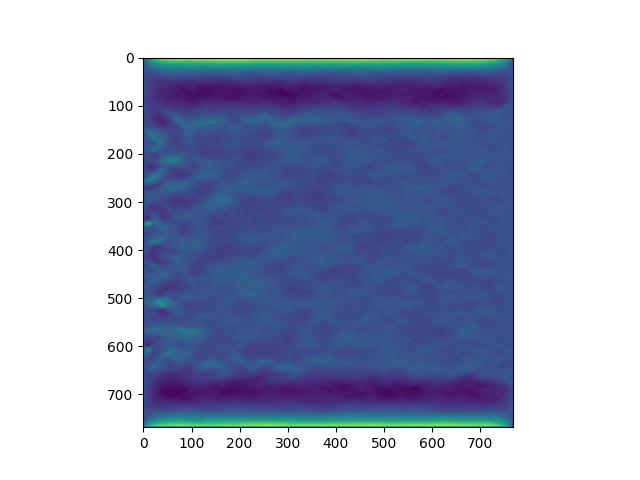

In [108]:
u,v=op.calc_uv(psi_data,dx,bc_fac=bc_fac)
plt.figure()
plt.imshow(u[-1,:,:])